In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import torch
import numpy as np
from matchers import constant, dataset, metrics, utils
from matchers.models.autoencoder import AutoEncoder, train_model

In [4]:
MAX_NAME_LENGTH = 30

### Load data

In [7]:
train, test = dataset.load_process_from_disk()

input_names_train, weighted_relevant_names_train, candidates_train = train
input_names_test, weighted_relevant_names_test, candidates_test = test

relevant_names_train = [[name for name, _, _ in name_weights] for name_weights in weighted_relevant_names_train]
relevant_names_test = [[name for name, _, _ in name_weights] for name_weights in weighted_relevant_names_test]

all_candidates = np.concatenate((candidates_train, candidates_test))

### Build token index mappings

In [8]:
char_to_idx_map, idx_to_char_map = utils.build_token_idx_maps()

### Convert names to ids

In [9]:
# Prepare data for training
# inputs and targets have the same data just in different representations 1-hot vs normal sequences
X_train_inputs, X_train_targets = utils.convert_names_model_inputs(candidates_train, 
                                                                   char_to_idx_map, 
                                                                   MAX_NAME_LENGTH)

### Model

In [10]:
model = AutoEncoder(input_size=constant.VOCAB_SIZE + 1, 
                    hidden_size=100,
                    num_layers=1,
                    seq_len=MAX_NAME_LENGTH)

In [11]:
train_model(model, X_train_inputs, X_train_targets, 100, 512)

100%|██████████| 100/100 [33:43<00:00, 20.23s/it, loss=0.117]


### Evaluation

In [12]:
# Convert test name inputs to correct format
X_test_inputs, X_test_targets = utils.convert_names_model_inputs(input_names_test,
                                                                 char_to_idx_map, 
                                                                 MAX_NAME_LENGTH)

# Get Embeddings for the names from the encoder
X_input_names_encoded = model(X_test_inputs, just_encoder=True).detach().numpy()

In [13]:
# Get embeddings for all candidate names (train + test)
X_test_candidate_inputs, _ = utils.convert_names_model_inputs(candidates_test, 
                                                              char_to_idx_map, 
                                                              MAX_NAME_LENGTH)
X_train_candidates_encoded = model(X_train_inputs, just_encoder=True).detach().numpy()
X_test_candidates_encoded = model(X_test_candidate_inputs, just_encoder=True).detach().numpy()

In [14]:
X_candidates_encoded = np.vstack((X_train_candidates_encoded, X_test_candidates_encoded))

In [18]:
k = 100
candidates = utils.get_candidates_batch(X_input_names_encoded, 
                                        X_candidates_encoded, 
                                        all_candidates,
                                        num_candidates=k)

In [19]:
candidate_names = candidates[:, :, 0]

### Evaluation

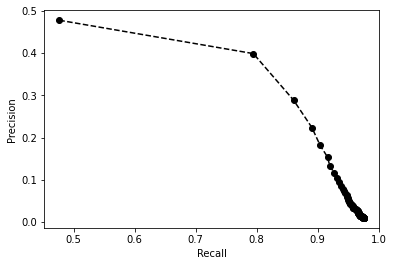

In [20]:
metrics.precision_recall_curve(relevant_names_test, candidate_names, k)

### mAP @ 1

In [ ]:
metrics.mean_avg_precision_k(relevant_names_test, candidate_names, 1)

### mAP @ 3

In [ ]:
metrics.mean_avg_precision_k(relevant_names_test, candidate_names, 3)

### Demo

In [ ]:
test_name = ['<schumacher>']
test_name, _ = utils.convert_names_model_inputs(test_name, char_to_idx_map, MAX_NAME_LENGTH)
test_name_embedding = model(test_name, just_encoder=True).detach().numpy()

utils.get_candidates_batch(test_name_embedding, 
                           X_candidates_encoded,
                           all_candidates,
                           num_candidates=10)